In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import warnings

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# --------------------- 2. Load and Validate Data ---------------------
try:
    df = pd.read_csv("C:\\Users\\HOME\\Downloads\\world_bank_data_2025.csv")
    # Convert year to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df['year']):
        df['year'] = pd.to_datetime(df['year'], format='%Y')
    print("Data loaded successfully. Shape:", df.shape)
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# Data validation
print("\nData Info:")
print(df.info())
print("\nDescriptive Statistics:")
print(df.describe(include='all'))
print("\nMissing Values:")
print(df.isnull().sum())

Data loaded successfully. Shape: (3472, 16)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3472 entries, 0 to 3471
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   country_name                     3472 non-null   object        
 1   country_id                       3472 non-null   object        
 2   year                             3472 non-null   datetime64[ns]
 3   Inflation (CPI %)                2694 non-null   float64       
 4   GDP (Current USD)                2933 non-null   float64       
 5   GDP per Capita (Current USD)     2938 non-null   float64       
 6   Unemployment Rate (%)            2795 non-null   float64       
 7   Interest Rate (Real, %)          1735 non-null   float64       
 8   Inflation (GDP Deflator, %)      2904 non-null   float64       
 9   GDP Growth (% Annual)            2912 non-null   float64       
 10  Curr

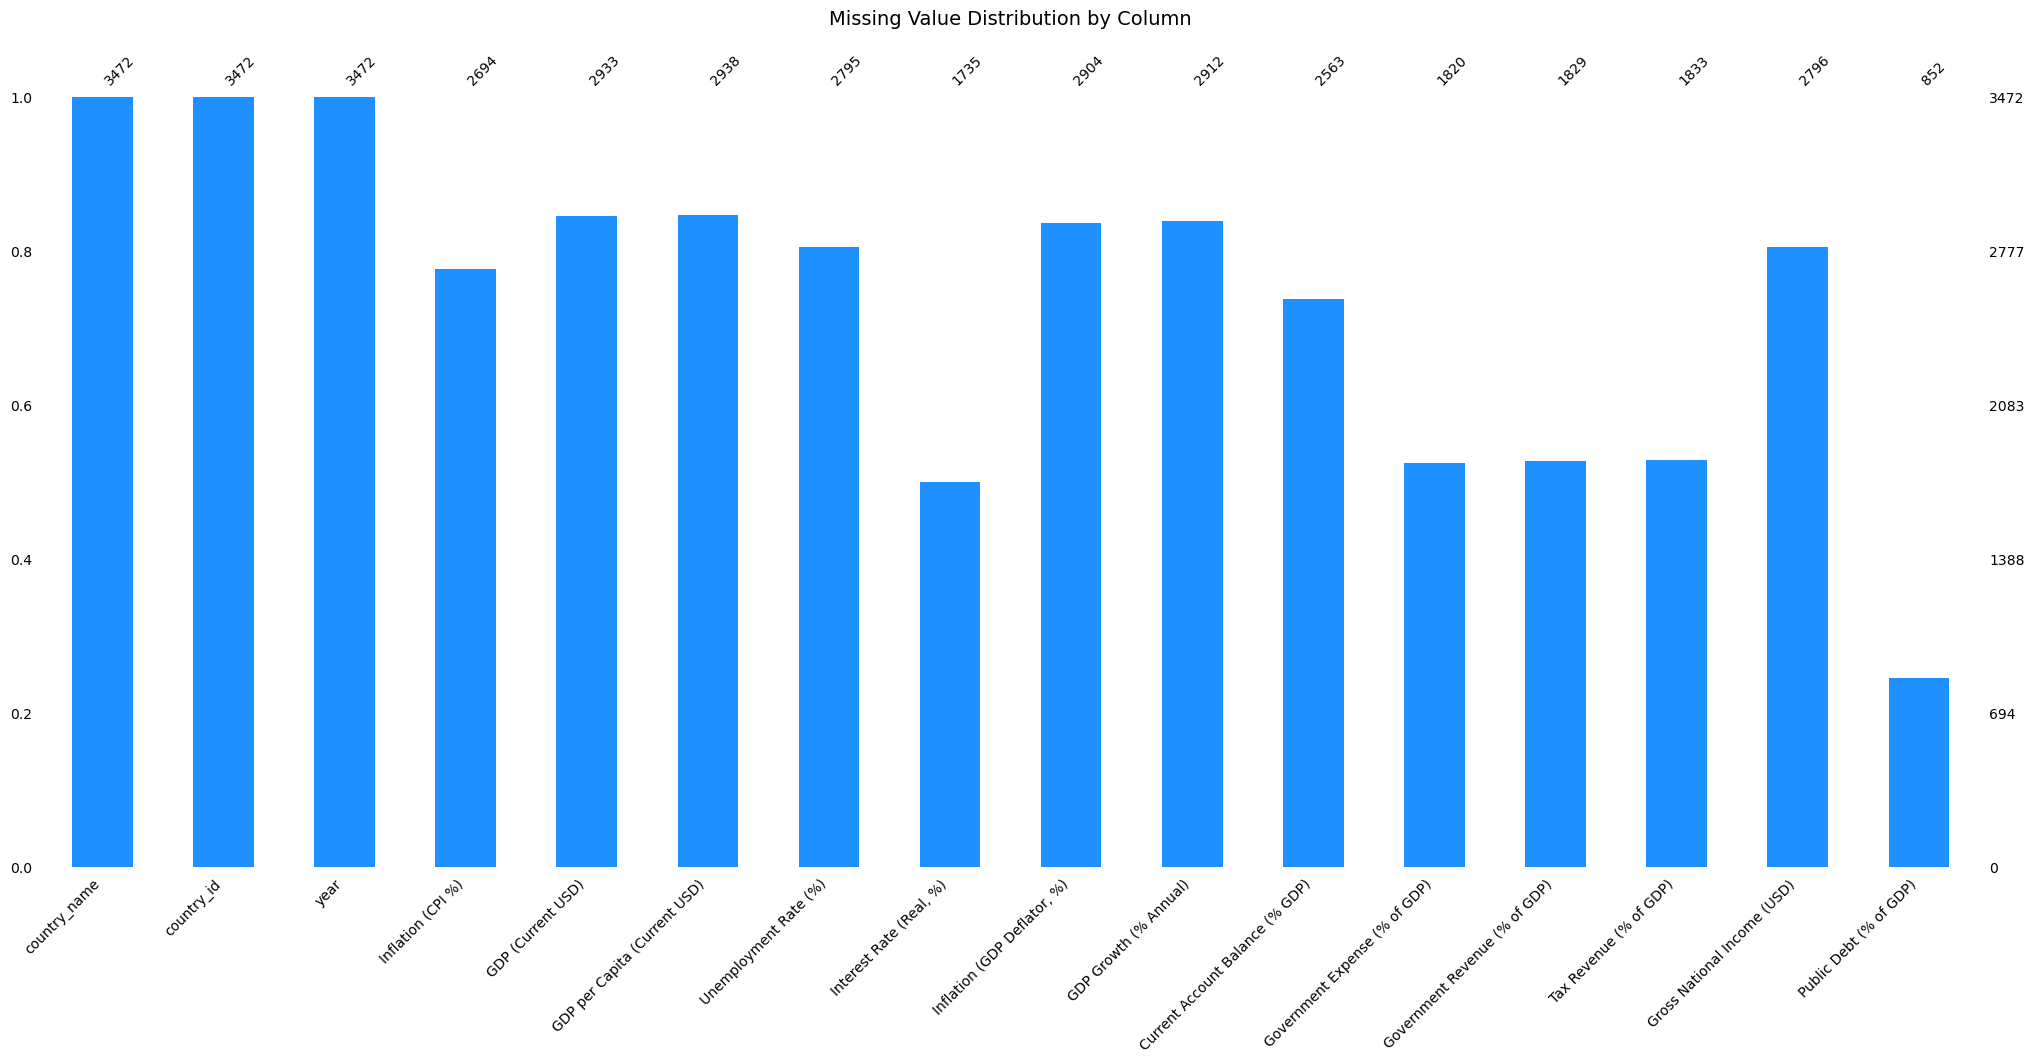


Missing Value Percentage:
Public Debt (% of GDP)             75.460829
Interest Rate (Real, %)            50.028802
Government Expense (% of GDP)      47.580645
Government Revenue (% of GDP)      47.321429
Tax Revenue (% of GDP)             47.206221
Current Account Balance (% GDP)    26.180876
Inflation (CPI %)                  22.407834
Unemployment Rate (%)              19.498848
Gross National Income (USD)        19.470046
Inflation (GDP Deflator, %)        16.359447
GDP Growth (% Annual)              16.129032
GDP (Current USD)                  15.524194
GDP per Capita (Current USD)       15.380184
dtype: float64


In [3]:
plt.figure(figsize=(12, 6))
msno.bar(df, color='dodgerblue', fontsize=10)
plt.title("Missing Value Distribution by Column", pad=20, fontsize=14)
plt.show()

# Calculate missing percentage
missing_percent = df.isnull().mean() * 100
print("\nMissing Value Percentage:")
print(missing_percent[missing_percent > 0].sort_values(ascending=False))

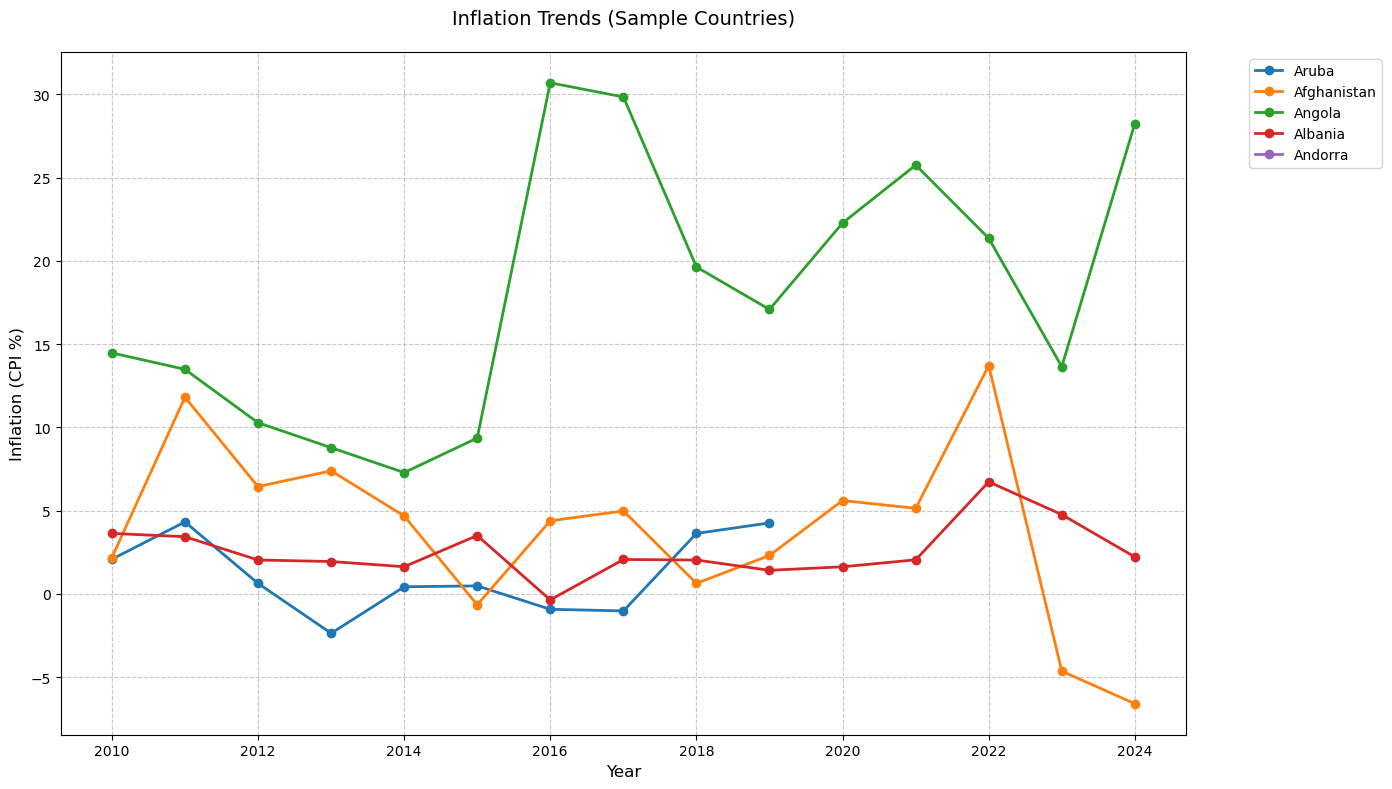

In [4]:
plt.figure(figsize=(14, 8))
# Use 'country_name' instead of 'country'
sample_countries = df['country_name'].dropna().unique()[:5]  # Top 5 countries

for country in sample_countries:
    country_data = df[df['country_name'] == country].sort_values('year')
    plt.plot(country_data['year'], country_data['Inflation (CPI %)'], 
             marker='o', linestyle='-', label=country, linewidth=2)

plt.title("Inflation Trends (Sample Countries)", fontsize=14, pad=20)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Inflation (CPI %)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

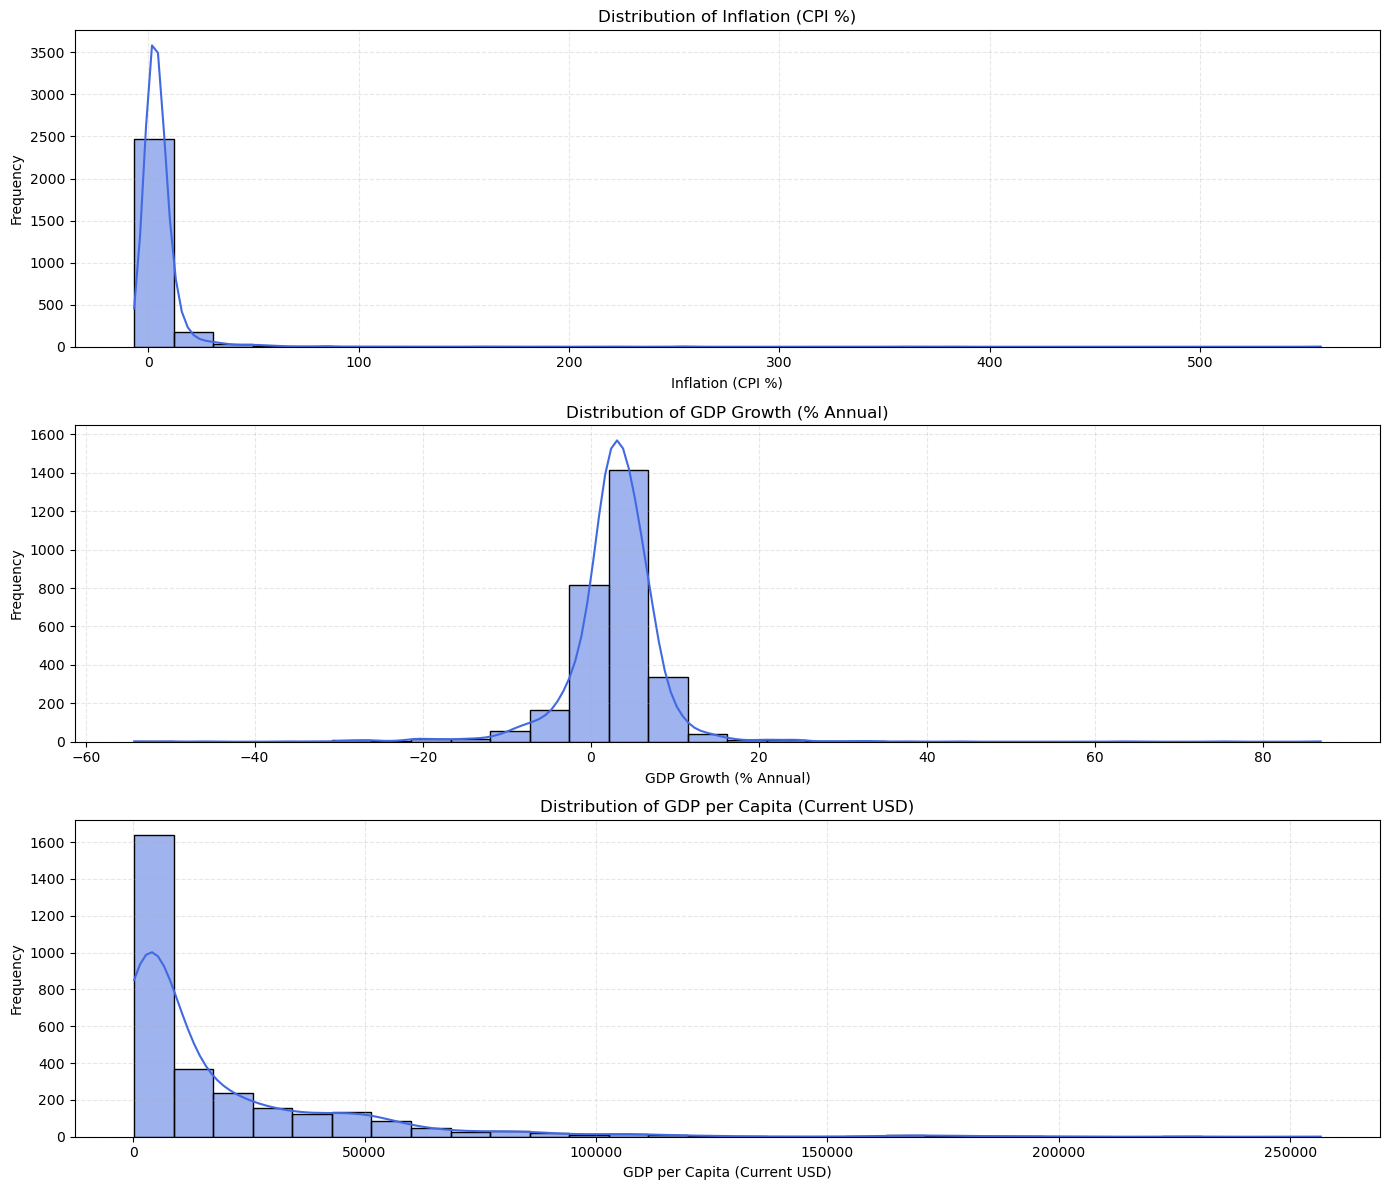

In [5]:
numeric_cols = ['Inflation (CPI %)', 'GDP Growth (% Annual)', 'GDP per Capita (Current USD)']
plt.figure(figsize=(14, 4 * len(numeric_cols)))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.histplot(df[col].dropna(), kde=True, color='royalblue', bins=30)
    plt.title(f'Distribution of {col}', fontsize=12)
    plt.xlabel(col, fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

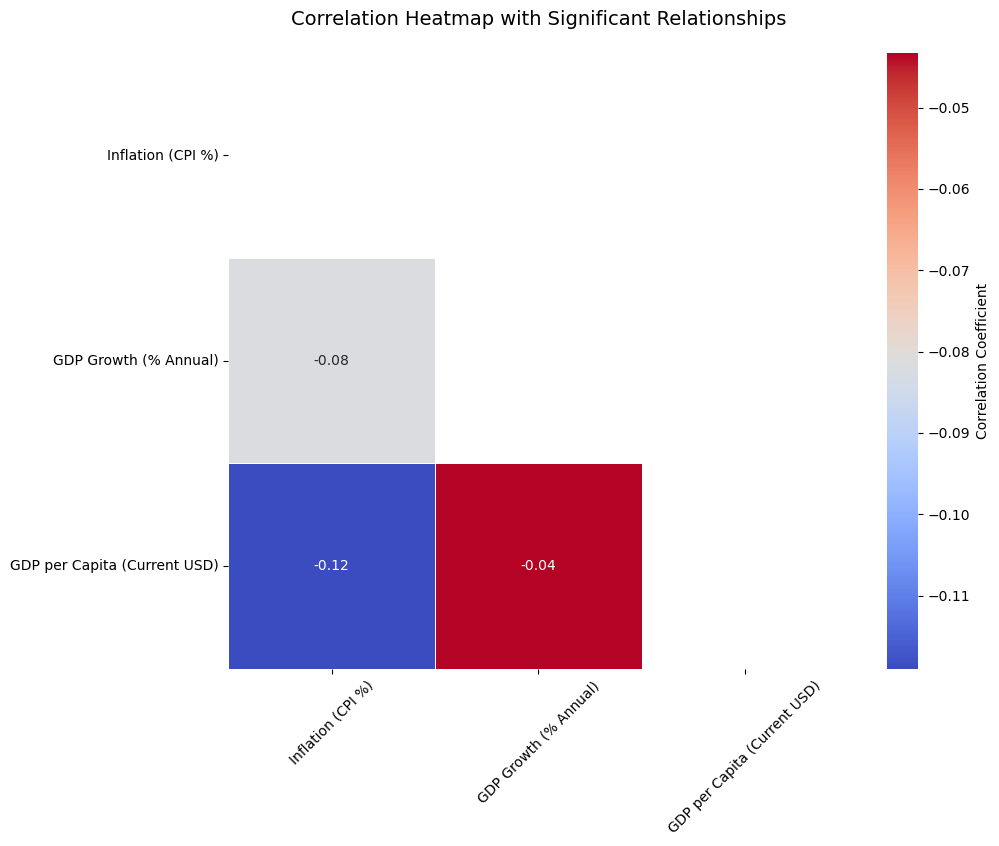


P-values for correlations:
                             Inflation (CPI %) GDP Growth (% Annual)  \
Inflation (CPI %)                          0.0              0.000036   
GDP Growth (% Annual)                 0.000036                   0.0   
GDP per Capita (Current USD)               0.0              0.029106   

                             GDP per Capita (Current USD)  
Inflation (CPI %)                                     0.0  
GDP Growth (% Annual)                            0.029106  
GDP per Capita (Current USD)                          0.0  


In [6]:
from scipy.stats import pearsonr

numeric_df = df[numeric_cols].dropna()
corr_matrix = numeric_df.corr()

# Calculate p-values
p_values = pd.DataFrame(index=numeric_cols, columns=numeric_cols)
for i in numeric_cols:
    for j in numeric_cols:
        p_values.loc[i, j] = pearsonr(numeric_df[i], numeric_df[j])[1]

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=np.triu(np.ones_like(corr_matrix)),
            cbar_kws={'label': 'Correlation Coefficient'}, fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap with Significant Relationships", fontsize=14, pad=20)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

print("\nP-values for correlations:")
print(p_values)

In [7]:
df.sort_values(by=['country_name', 'year'], inplace=True)

# Time-based features
def create_time_features(group):
    group = group.sort_values('year')
    # Lag features
    group['inflation_lag1'] = group['Inflation (CPI %)'].shift(1)
    group['gdp_growth_lag1'] = group['GDP Growth (% Annual)'].shift(1)
    # Rolling statistics
    group['gdp_growth_rolling3'] = group['GDP Growth (% Annual)'].rolling(3, min_periods=1).mean()
    group['inflation_rolling3'] = group['Inflation (CPI %)'].rolling(3, min_periods=1).mean()
    # Percentage changes
    group['gdp_pc_growth'] = group['GDP per Capita (Current USD)'].pct_change()
    # Year-over-year differences
    group['inflation_diff'] = group['Inflation (CPI %)'].diff()
    return group

df = df.groupby('country_name', group_keys=False).apply(create_time_features)


In [8]:
# Drop rows where target or essential features are missing
df.dropna(subset=['Inflation (CPI %)', 'inflation_lag1', 'gdp_growth_lag1'], inplace=True)

In [9]:
features = ['inflation_lag1', 'gdp_growth_lag1', 'gdp_pc_growth',
            'gdp_growth_rolling3', 'inflation_rolling3', 'inflation_diff', 'country_name']
target = 'Inflation (CPI %)'


In [10]:
missing_features = [f for f in features if f not in df.columns]
if missing_features:
    print(f"Warning: Missing features {missing_features}")
    features = [f for f in features if f in df.columns]

X = df[features]
y = df[target]

In [11]:
numeric_features = [col for col in features if col != 'country_name']
categorical_features = ['country_name']

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

In [13]:
min_year, max_year = df['year'].min(), df['year'].max()
split_year = pd.to_datetime('2015-01-01')  # Convert to datetime for comparison

if split_year <= min_year or split_year >= max_year:
    split_year = min_year + (max_year - min_year) * 0.8  # 80-20 split if 2015 is invalid
    print(f"Adjusted split year to {split_year}")

train_df = df[df['year'] <= split_year]
test_df = df[df['year'] > split_year]

print(f"\nTrain size: {len(train_df)}, Test size: {len(test_df)}")
print(f"Train period: {train_df['year'].min()} to {train_df['year'].max()}")
print(f"Test period: {test_df['year'].min()} to {test_df['year'].max()}")

# Preprocess data
X_train = preprocessor.fit_transform(train_df[features])
y_train = train_df[target]
X_test = preprocessor.transform(test_df[features])
y_test = test_df[target]


Train size: 938, Test size: 1542
Train period: 2011-01-01 00:00:00 to 2015-01-01 00:00:00
Test period: 2016-01-01 00:00:00 to 2024-01-01 00:00:00


In [14]:
def build_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,), kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

model = build_model(X_train.shape[1])

In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

In [16]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 51.7731 - mae: 4.9929 - val_loss: 244.8190 - val_mae: 7.8627 - learning_rate: 0.0010
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 41.8748 - mae: 4.4490 - val_loss: 236.1926 - val_mae: 7.6662 - learning_rate: 0.0010
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 38.5022 - mae: 3.9682 - val_loss: 225.0324 - val_mae: 7.4293 - learning_rate: 0.0010
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 28.0377 - mae: 3.3219 - val_loss: 211.1954 - val_mae: 7.1435 - learning_rate: 0.0010
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 23.3473 - mae: 3.1414 - val_loss: 196.1016 - val_mae: 6.8236 - learning_rate: 0.0010
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 14.7089 - mae: 2.5105 - val_loss: 181.9715 - val_mae: 6.5120 - learning_rate: 0.0010
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 12.5630 - mae: 2.3747 - val_loss: 169.4853 - val_mae: 6.2157 - learnin

In [17]:
y_pred = model.predict(X_test).flatten()

metrics = {
    'R² Score': r2_score(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'MAE': mean_absolute_error(y_test, y_pred),
    'MAPE': np.mean(np.abs((y_test - y_pred) / y_test)) * 100
}

print("\nModel Performance Metrics:")
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Model Performance Metrics:
R² Score: 0.9903
MSE: 5.4984
RMSE: 2.3449
MAE: 1.0647
MAPE: 52.2109


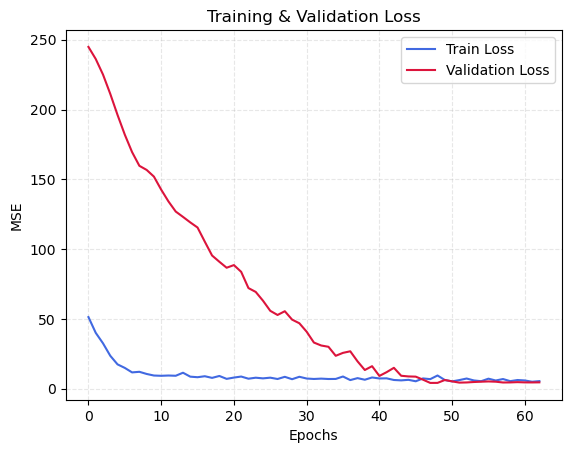

In [19]:
# Loss Curve

plt.plot(history.history['loss'], label='Train Loss', color='royalblue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='crimson')
plt.title("Training & Validation Loss", fontsize=12)
plt.xlabel("Epochs", fontsize=10)
plt.ylabel("MSE", fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)

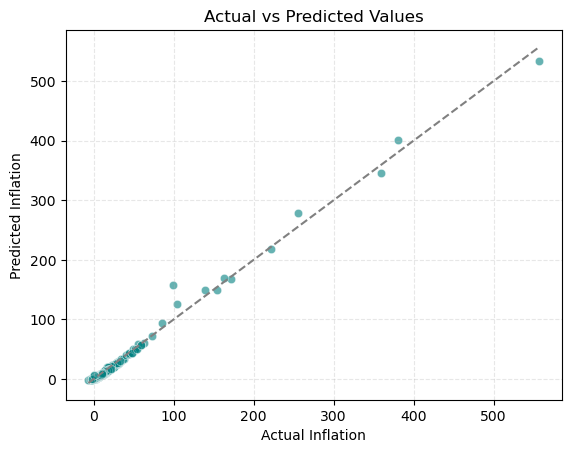

In [21]:

max_val = max(y_test.max(), y_pred.max())
min_val = min(y_test.min(), y_pred.min())
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='teal')
plt.plot([min_val, max_val], [min_val, max_val], '--', color='gray')
plt.xlabel("Actual Inflation", fontsize=10)
plt.ylabel("Predicted Inflation", fontsize=10)
plt.title("Actual vs Predicted Values", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)

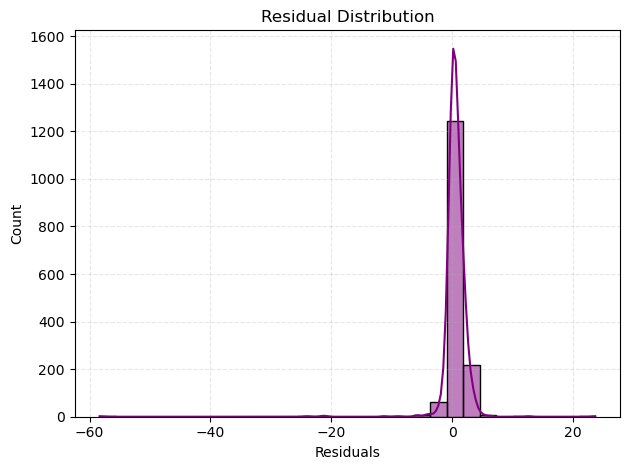

In [23]:

residuals = y_test - y_pred
sns.histplot(residuals, kde=True, color='purple', bins=30)
plt.title("Residual Distribution", fontsize=12)
plt.xlabel("Residuals", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
print("\nRunning Time Series Cross Validation...")
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = {'MSE': [], 'MAE': [], 'R2': []}

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    fold_model = build_model(X_train.shape[1])
    fold_model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32, verbose=0)
    
    y_val_pred = fold_model.predict(X_val_fold).flatten()
    
    cv_scores['MSE'].append(mean_squared_error(y_val_fold, y_val_pred))
    cv_scores['MAE'].append(mean_absolute_error(y_val_fold, y_val_pred))
    cv_scores['R2'].append(r2_score(y_val_fold, y_val_pred))
    
    print(f"Fold {fold}: MSE={cv_scores['MSE'][-1]:.4f}, MAE={cv_scores['MAE'][-1]:.4f}, R²={cv_scores['R2'][-1]:.4f}")

print("\nCross Validation Averages:")
for metric, scores in cv_scores.items():
    print(f"Mean {metric}: {np.mean(scores):.4f} (±{np.std(scores):.4f})")


Running Time Series Cross Validation...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Fold 1: MSE=4.1005, MAE=1.4661, R²=0.7648
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000018107537740> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Fold 2: MSE=2.8482, MAE=1.0779, R²=0.9043
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/st